In [1]:
import os
import sys
import subprocess

os.environ["FLAGS_allocator_strategy"] = 'auto_growth'
import matplotlib.pyplot as plt
import cv2
import copy
import numpy as np
import json
import time
import logging
from PIL import Image
import tools.infer.utility as utility
import tools.infer.predict_rec as predict_rec
import tools.infer.predict_det as predict_det
import tools.infer.predict_cls as predict_cls
from tools.infer.predict_system import TextSystem
from ppocr.utils.utility import get_image_file_list, check_and_read_gif
from ppocr.utils.logging import get_logger
from tools.infer.utility import draw_ocr_box_txt, get_rotate_crop_image
import argparse
logger = get_logger()


In [2]:
text_detector = './inference/en_PP-OCRv3_det_infer.onnx'
text_recognizer = './inference/PPOCRv3_rec_lisenceplate_14112022.onnx'
text_classifier = './inference/ch_ppocr_mobile_v2.0_cls_infer.onnx'
use_onnx = True

In [3]:
from paddleocr_config import get_config
args = get_config()

In [4]:
path_test = '/home/os/Desktop/SETA/Seta_Car/output_model/bienso'

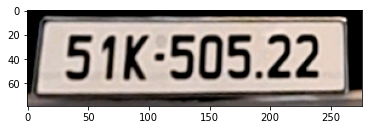

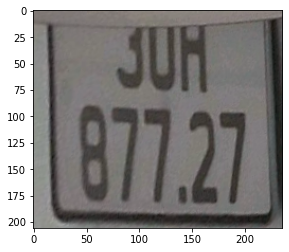

In [5]:
for img_name in os.listdir(path_test):
    fig, ax = plt.subplots(1,1)
    img_path = os.path.join(path_test,img_name)
    img_plot = Image.open(img_path)
    plt.imshow(img_plot)

    args.image_dir = img_path
    image_file = args.image_dir
    text_sys = TextSystem(args)


    save_results = []
    total_time = 0
    cpu_mem, gpu_mem, gpu_util = 0, 0, 0
    _st = time.time()
    count = 0

    img = cv2.imread(image_file)
    if img is None:
        logger.debug("error in loading image:{}".format(image_file))

    starttime = time.time()
    dt_boxes, rec_res = text_sys(img)
    elapse = time.time() - starttime
    total_time += elapse

    # for text, score in rec_res:
    #     logger.debug("{}, {:.3f}".format(text, score))
    print(str(img_name) + "  Predict time of %s: %.3fs" % (image_file, elapse))
    for text, score in rec_res:
        print(text, score)
    # res = [{
    #     "transcription": rec_res[idx][0],
    #     "points": np.array(dt_boxes[idx]).astype(np.int32).tolist(),
    # } for idx in range(len(dt_boxes))]
    # print(res)

In [6]:
args.image_dir = '/home/os/Desktop/SETA/Seta_Car/output_model/bienso/1668701874.png'
image_file = args.image_dir
text_sys = TextSystem(args)


save_results = []
total_time = 0
cpu_mem, gpu_mem, gpu_util = 0, 0, 0
_st = time.time()
count = 0

img = cv2.imread(image_file)
if img is None:
    logger.debug("error in loading image:{}".format(image_file))

starttime = time.time()
dt_boxes, rec_res = text_sys(img)
elapse = time.time() - starttime
total_time += elapse

# for text, score in rec_res:
#     logger.debug("{}, {:.3f}".format(text, score))
print(str(image_file) + "  Predict time of %s: %.3fs" % (image_file, elapse))
res = [{
    "transcription": rec_res[idx][0],
    "points": np.array(dt_boxes[idx]).astype(np.int32).tolist(),
} for idx in range(len(dt_boxes))]
res 


/home/os/Desktop/SETA/Seta_Car/output_model/bienso/1668701874.png  Predict time of /home/os/Desktop/SETA/Seta_Car/output_model/bienso/1668701874.png: 0.263s


[{'transcription': '30H', 'points': [[38, 13], [82, 9], [84, 37], [41, 41]]},
 {'transcription': '622.92',
  'points': [[20, 57], [91, 44], [96, 82], [25, 94]]}]

In [8]:
image_file_list = get_image_file_list(args.image_dir)
image_file_list = image_file_list[args.process_id::args.total_process_num]
text_sys = TextSystem(args)
is_visualize = True
font_path = args.vis_font_path
drop_score = args.drop_score
draw_img_save_dir = args.draw_img_save_dir
os.makedirs(draw_img_save_dir, exist_ok=True)
save_results = []

logger.info("In PP-OCRv3, rec_image_shape parameter defaults to '3, 48, 320', "
            "if you are using recognition model with PP-OCRv2 or an older version, please set --rec_image_shape='3,32,320")

# warm up 10 times
if args.warmup:
    img = np.random.uniform(0, 255, [640, 640, 3]).astype(np.uint8)
    for i in range(10):
        res = text_sys(img)

total_time = 0
cpu_mem, gpu_mem, gpu_util = 0, 0, 0
_st = time.time()
count = 0
for idx, image_file in enumerate(image_file_list):

    img, flag = check_and_read_gif(image_file)
    if not flag:
        img = cv2.imread(image_file)
    if img is None:
        logger.debug("error in loading image:{}".format(image_file))
        continue
    starttime = time.time()
    dt_boxes, rec_res = text_sys(img)
    elapse = time.time() - starttime
    total_time += elapse

    logger.debug(
        str(idx) + "  Predict time of %s: %.3fs" % (image_file, elapse))
    for text, score in rec_res:
        logger.debug("{}, {:.3f}".format(text, score))

    res = [{
        "transcription": rec_res[idx][0],
        "points": np.array(dt_boxes[idx]).astype(np.int32).tolist(),
    } for idx in range(len(dt_boxes))]
    save_pred = os.path.basename(image_file) + "\t" + json.dumps(
        res, ensure_ascii=False) + "\n"
    save_results.append(save_pred)

    if is_visualize:
        image = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        boxes = dt_boxes
        txts = [rec_res[i][0] for i in range(len(rec_res))]
        scores = [rec_res[i][1] for i in range(len(rec_res))]
        print('boxes: ',boxes)
        print('txts: ',txts)
        print('scores: ', scores)
        draw_img = draw_ocr_box_txt(
            image,
            boxes,
            txts,
            scores,
            drop_score=drop_score,
            font_path=font_path)
        if flag:
            image_file = image_file[:-3] + "png"
        cv2.imwrite(
            os.path.join(draw_img_save_dir, os.path.basename(image_file)),
            draw_img[:, :, ::-1])
        logger.debug("The visualized image saved in {}".format(
            os.path.join(draw_img_save_dir, os.path.basename(image_file))))

logger.info("The predict total time is {}".format(time.time() - _st))
if args.benchmark:
    text_sys.text_detector.autolog.report()
    text_sys.text_recognizer.autolog.report()

if args.total_process_num > 1:
    save_results_path = os.path.join(draw_img_save_dir, f"system_results_{args.process_id}.txt")
else:
    save_results_path = os.path.join(draw_img_save_dir, "system_results.txt")

with open(save_results_path, 'w', encoding='utf-8') as f:
    f.writelines(save_results)

[2022/11/18 16:10:24] ppocr INFO: In PP-OCRv3, rec_image_shape parameter defaults to '3, 48, 320', if you are using recognition model with PP-OCRv2 or an older version, please set --rec_image_shape='3,32,320
boxes:  [array([[38., 13.],
       [82.,  9.],
       [84., 37.],
       [41., 41.]], dtype=float32), array([[20., 57.],
       [91., 44.],
       [96., 82.],
       [25., 94.]], dtype=float32)]
txts:  ['00G', '622.92']
scores:  [0.8273060917854309, 0.9999507069587708]
[2022/11/18 16:10:24] ppocr INFO: The predict total time is 0.2851436138153076
